## Running conv-nets
This ipython notebook walks you through the running_template.py script.

First, we need to load the necessary python modules

In [1]:
%matplotlib inline
import h5py
import tifffile as tiff
#from keras.backend.common import _UID_PREFIXES

from cnn_functions import nikon_getfiles, get_image, run_models_on_directory, get_image_sizes, segment_nuclei, segment_cytoplasm, dice_jaccard_indices
from model_zoo import sparse_bn_feature_net_61x61 as cyto_fn
from model_zoo import sparse_bn_feature_net_61x61 as nuclear_fn

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.io import imshow, imread

from scipy import ndimage

#import seaborn as sns
#sns.set_context('poster')

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
Traceback (most recent call last):
  File "/home/amandap/anaconda3/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 23, in <module>
    import pygpu
ImportError: No module named pygpu
Using Theano backend.


**had to fix syntax for later version of python in:**
- cnn_functions.py
- model_zoo.py
- line 5

Next, we need to specify some directory locations - namely where the home data directory is (direc_name), where the raw images are located (data_location), where to store they cytoplasm prediction images (cyto_location), where to store the nuclear prediction images (nuclear_location), and where to store the final segmentation masks (mask_location)

In [2]:
direc_name = '/home/amandap/data/deepCellData/validation_data'
data_location = os.path.join(direc_name, 'RawImages/set3')
#data_location = '/home/amandap/DeepCell/validation_data/MCF10A/RawImages'
cyto_location = os.path.join(direc_name, 'Cytoplasm')
nuclear_location = os.path.join(direc_name, 'Nuclear')
mask_location = os.path.join(direc_name, 'Masks')
print(data_location)

/home/amandap/data/deepCellData/validation_data/RawImages/set3


Next, we need to define the channel names. In this case, the cytoplasm network takes in phase and nuclear marker (far red) images. The channel names have to be present in the file names. We also need to specify the directory the conv-net parameter files live in and what the file names are.

In [3]:
cyto_channel_names = ['img', 'nuc']
nuclear_channel_names = ['nuc']

trained_network_cyto_directory = "/home/amandap/DeepCellKimmel/trained_networks"
trained_network_nuclear_directory = "/home/amandap/DeepCellKimmel/trained_networks"

cyto_prefix = "2017-12-08_AT22LA_all_61x61_2_20171207_AT22LA_bn_feature_net_61x61_"
nuclear_prefix = "2017-12-10_AT22LA_nuclei_61x61_20171209_nuclei_bn_feature_net_61x61_"

We are using a network that takes in 61x61 images in this example. We need to manually feed in the window size (the number of pixels sampled around each pixels). We also need to specify the image size.

In [4]:
win_cyto = 30
win_nuclear = 30

image_size_x, image_size_y = get_image_sizes(data_location, nuclear_channel_names)
print(image_size_x, image_size_y)

(512, 512)


Now we need to load the weights for the networks. Remember we make use of two networks - one for the cytoplasm and another for the nucleus. Because we use model parallelism, we have 5 networks for each segmentation task.

In [5]:
list_of_cyto_weights = []
list_of_cyto_weights += ['/home/amandap/DeepCellKimmel/trained_networks/2017-12-07_AT22LA_all_61x61_2_20171207_AT22LA_bn_feature_net_61x61_0.h5']
list_of_cyto_weights += ['/home/amandap/DeepCellKimmel/trained_networks/2017-12-08_AT22LA_all_61x61_2_20171207_AT22LA_bn_feature_net_61x61_1.h5']
list_of_cyto_weights += ['/home/amandap/DeepCellKimmel/trained_networks/2017-12-08_AT22LA_all_61x61_2_20171207_AT22LA_bn_feature_net_61x61_2.h5']


#for j in range(3):
#	cyto_weights = os.path.join(trained_network_cyto_directory,  cyto_prefix + str(j) + ".h5")
#	list_of_cyto_weights += [cyto_weights]

list_of_nuclear_weights = []
for j in range(5):
	nuclear_weights = os.path.join(trained_network_nuclear_directory,  nuclear_prefix + str(j) + ".h5")
	list_of_nuclear_weights += [nuclear_weights]

#print(list_of_cyto_weights)
#print(list_of_nuclear_weights)

Next, we run all our networks on all the files in our directory.

In [13]:
cytoplasm_predictions = run_models_on_directory(data_location, cyto_channel_names, 
                                                cyto_location, model_fn = cyto_fn, 
                                                list_of_weights = list_of_cyto_weights, 
                                                image_size_x = image_size_x, image_size_y = image_size_y, 
                                                win_x = win_cyto, win_y = win_cyto, 
                                                std=True, split = False)

Processing image 1 of 1
Processing image 1 of 1
Processing image 1 of 1


In [14]:
#nuclear_predictions = run_models_on_directory(data_location, nuclear_channel_names, nuclear_location, model_fn = nuclear_fn, 
#	list_of_weights = list_of_nuclear_weights, image_size_x = image_size_x, image_size_y = image_size_y, 
#	win_x = win_nuclear, win_y = win_nuclear, std=True, split = False)

Next, we need to refine the neural network predictions to create segmentation masks. The smoothing and num_iters parameters control the active contour refinement process.

(1, 512, 512)
(1, 3, 512, 512)


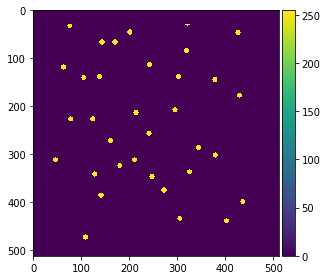

In [15]:
#nuclear_masks = segment_nuclei(nuclear_predictions, mask_location = mask_location, threshold = 0.9, area_threshold = 20, solidity_threshold = 0.75, eccentricity_threshold = 0.95)
nuclear_masks=np.zeros((1,512,512))

#nuclear_masks[0,:,:]=imread('/home/amandap/data/deepCellData/validation_data/RawImages/set1/m05s01nuc04.tif')
#nuclear_masks[0,:,:]=imread('/home/amandap/data/deepCellData/validation_data/RawImages/set2/m05s07nuc05.tif')
nuclear_masks[0,:,:]=imread('/home/amandap/data/deepCellData/validation_data/RawImages/set3/m54s03nuc06.tif')
#nuclear_masks[3,:,:]=imread('/home/amandap/data/deepCellData/validation_data/RawImages/m54s07nuc07.tif')

nuclear_masks[0,0:win_nuclear,:]=0
nuclear_masks[0,:,0:win_nuclear]=0
nuclear_masks[0,-win_nuclear:,:]=0
nuclear_masks[0,:,-win_nuclear:]=0

#nuclear_masks=np.expand_dims(nuclear_masks, axis=0)
print(nuclear_masks.shape)
print(cytoplasm_predictions.shape)
imshow(nuclear_masks[0,:,:])

In [33]:
cytoplasm_masks = segment_cytoplasm(cytoplasm_predictions, nuclear_masks = nuclear_masks, mask_location = mask_location, smoothing = 1, num_iters = 120)
#cytoplasm_masks = segment_cytoplasm(cytoplasm_predictions, nuclear_masks = cytoplasm_masks, mask_location = mask_location, smoothing = 1, num_iters = 50)
#cytoplasm_masks = segment_cytoplasm(cytoplasm_predictions, nuclear_masks = cytoplasm_masks, mask_location = mask_location, smoothing = 1, num_iters = 50)
#cytoplasm_masks = segment_nuclei(cytoplasm_predictions, mask_location = mask_location, threshold = 0.3, area_threshold = 10, solidity_threshold = .9, eccentricity_threshold = 1)

With the masks computed, if a reference segmentation is available, we can test our conv-net segmentation against them to compute the Jaccard and Dice indices.

In [51]:
#direc_val='/home/amandap/DeepCell/validation_data/MCF10A/Validation'
direc_val = os.path.join(direc_name, 'Validation/set3')
imglist_val = nikon_getfiles(direc_val, 'cyto')

val_name = os.path.join(direc_val, imglist_val[0]) 
val = get_image(val_name)
val = val[win_cyto:-win_cyto,win_cyto:-win_cyto]
val_new=np.zeros(val.shape)
val_new[val==0]=255
val=val_new
cyto = cytoplasm_masks[0,win_cyto:-win_cyto,win_cyto:-win_cyto]
nuc = nuclear_masks[0,win_cyto:-win_cyto,win_cyto:-win_cyto]
dice_jaccard_indices(cyto, val, nuc)

[0.18546733, 0.31813523, 0.27150428, 0.22222222, 0.17363852, 0.36279827, 0.10379241, 0.081555404, 0.40359128, 0.46362081, 0.26512524, 0.33657351, 0.40998486, 0.082978025, 0.55998355, 0.15138023, 0.44002891, 0.19288889, 0.10723089, 0.21492884, 0.21333718, 0.31578946, 0.50449103, 0.38658652, 0.51118112, 0.37609196, 0.63661456, 0.213422, 0.13378803, 0.14200832, 0.17307216, 0.59316903, 0.36770073, 0.425731] [0.31290163124073156, 0.48270501360279827, 0.42705995511381856, 0.36363636363636365, 0.29589778076664425, 0.53243135694389176, 0.18806509945750452, 0.15081132675787465, 0.5750837648492233, 0.63352585258525851, 0.419128845568078, 0.50363636363636366, 0.58154506437768239, 0.1532404603270745, 0.71793521200948118, 0.26295436968290797, 0.61113898645258402, 0.32339791356184799, 0.19369202226345084, 0.35381305283289505, 0.35165358077563647, 0.47999999999999998, 0.6706467661691542, 0.55760894364590463, 0.67653188828678612, 0.54660875375877049, 0.77796514896008995, 0.35176880916791231, 0.2360018

(0.30412975, 0.44572657480229833)

(1, 3, 512, 512)


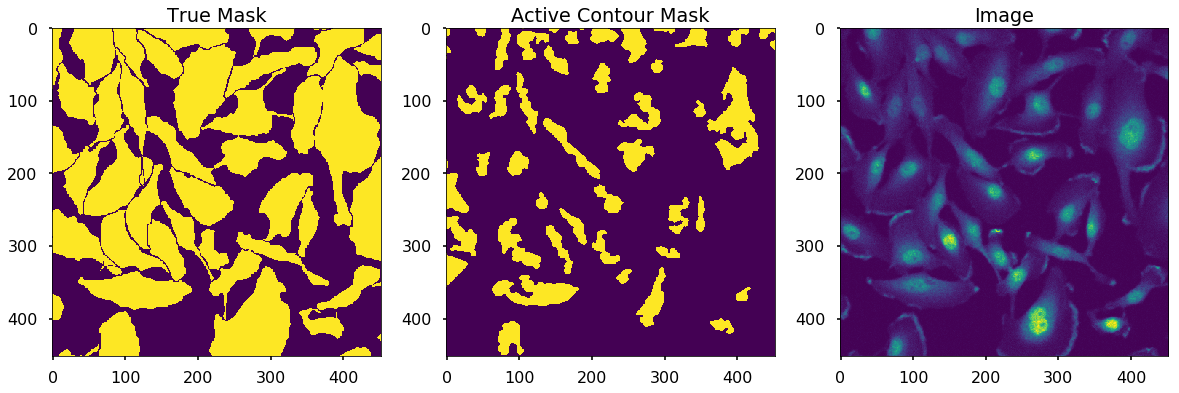

In [52]:
plt.style.use('seaborn-poster')
I=imread('/home/amandap/data/deepCellData/validation_data/RawImages/set3/m54s03img06.tif')
f, axs = plt.subplots(1,3,figsize=(20,15))
#plt.suptitle('Jaccard index 0.30 +/- 0.15\nDice index 0.46 +/- 0.18')
plt.subplot(1,3,1)
plt.title("True Mask")
plt.imshow(val)
plt.subplot(1,3,2)
plt.title("Active Contour Mask")
plt.imshow(cyto)
plt.subplot(1,3,3)
plt.title("Image")
plt.imshow(I[win_cyto:-win_cyto,win_cyto:-win_cyto])
print(cytoplasm_predictions.shape)

In [45]:
cyto_masks=np.zeros(cytoplasm_predictions.shape)
for i in range(cytoplasm_predictions.shape[2]):
    for j in range(cytoplasm_predictions.shape[3]):
        for k in range(cytoplasm_predictions.shape[0]):
            zidx=[np.argmax(cytoplasm_predictions[k,:,i-1,j-1])]
            #print zidx
            not_in_indices = [x for x in range(cytoplasm_predictions.shape[1]) if x not in zidx]
            #print(not_in_indices)
            cyto_masks[k,not_in_indices,i-1,j-1] = 0
            cyto_masks[k,zidx,i-1,j-1]=1

In [46]:
#Irgb=np.rollaxis(cyto_masks[0,:,:,:],0,3)
#direc_val = os.path.join(direc_name, 'Validation/set2')
#imglist_val = nikon_getfiles(direc_val, 'cyto')

#val_name = os.path.join(direc_val, imglist_val[0]) 
#val = get_image(val_name)
#val = val[win_cyto:-win_cyto,win_cyto:-win_cyto]

(1, 3, 512, 512)


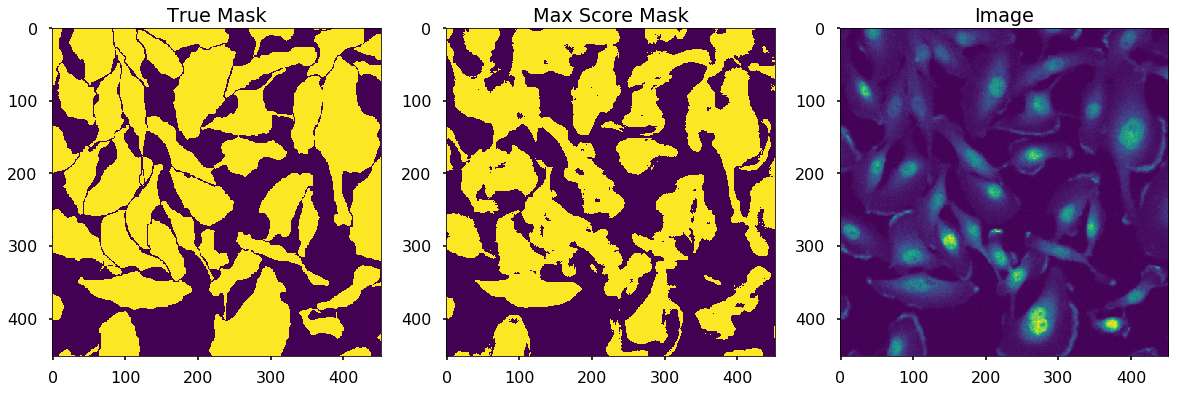

In [53]:
#I=imread('/home/amandap/data/deepCellData/validation_data/RawImages/set1/m05s01img04.tif')
#plt.suptitle('Jaccard Index = 0.26 +/- .11\nDice index = 0.40 +/- .13')
f, axs = plt.subplots(1,3,figsize=(20,15))
plt.subplot(1,3,1)
plt.title("True Mask")
plt.imshow(val)
plt.subplot(1,3,2)
plt.title("Max Score Mask")
plt.imshow(cyto_masks[0, 0, win_cyto:-win_cyto,win_cyto:-win_cyto])
plt.subplot(1,3,3)
plt.title("Image")
plt.imshow(I[win_cyto:-win_cyto,win_cyto:-win_cyto])
print(cytoplasm_predictions.shape)

In [54]:
#val_name = os.path.join(direc_val, imglist_val[0]) 
#val = get_image(val_name)
#val = val[win_cyto:-win_cyto,win_cyto:-win_cyto]
cyto = cyto_masks[0,0,win_cyto:-win_cyto,win_cyto:-win_cyto]
nuc = nuclear_masks[0,win_cyto:-win_cyto,win_cyto:-win_cyto]
dice_jaccard_indices(cyto, val, nuc)

[0.058944322, 0.041569889, 0.067472398, 0.68915224, 0.10214253, 0.050552733, 0.13608101, 0.10923943, 0.060338419, 0.29670098, 0.065689094, 0.071122818, 0.11286209, 0.11857507, 0.065982886, 0.084203281, 0.82677168, 0.059959471, 0.10818413, 0.070750318, 0.26821104, 0.10599946, 0.068110429, 0.74582559, 0.15426862, 0.10225105, 0.057504982, 0.098756842, 0.095264226, 0.37490258, 0.2773419, 0.22688666, 0.25266242, 0.81957185] [0.11132657799142381, 0.079821602149922802, 0.12641525257890471, 0.81597409606044258, 0.18535266027130964, 0.096240259370911782, 0.23956215008410534, 0.19696276263781984, 0.11380973749158627, 0.45762438252671683, 0.12328004010918611, 0.13280049185367354, 0.20283211917819433, 0.21201091901728844, 0.12379727008279257, 0.15532747857369592, 0.90517241379310343, 0.11313540260908682, 0.19524576560745838, 0.13215092081281793, 0.42297541325184052, 0.19168085623935782, 0.12753443739359233, 0.85441020191285866, 0.2673010788147171, 0.1855313257182416, 0.10875595331553881, 0.1797610

(0.20128977, 0.29071905234408607)

In [55]:
thresh=imread('/home/amandap/data/deepCellData/validation_data/m54s03img06_mean.tif')

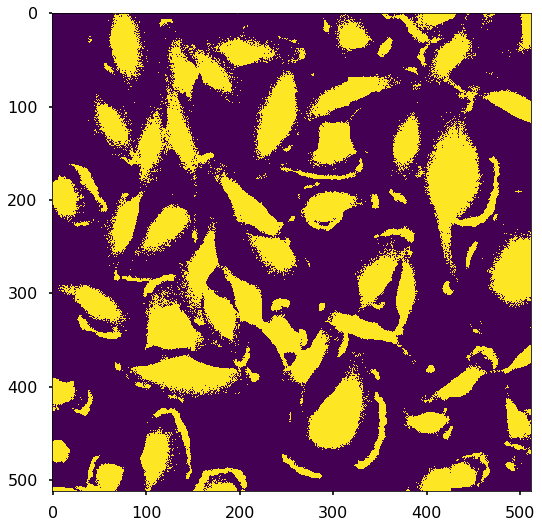

In [56]:
plt.imshow(thresh)

In [57]:
cyto=thresh[win_cyto:-win_cyto,win_cyto:-win_cyto]

In [58]:
dice_jaccard_indices(cyto, val, nuc)

[0.30713201, 0.17732064, 0.47027686, 0.30190796, 0.36975679, 0.14809431, 0.3866114, 0.56105834, 0.23125505, 0.53787035, 0.20623943, 0.40899879, 0.45670474, 0.36360657, 0.6362564, 0.31525123, 0.55275476, 0.55006558, 0.20194711, 0.32879046, 0.25370869, 0.22174209, 0.18431142, 0.34704208, 0.58908463, 0.16080074, 0.11613182, 0.23381139, 0.14134182, 0.49029681, 0.38202107, 0.58952522, 0.57347971, 0.33488372] [0.46993266775017412, 0.30122743682310471, 0.63971199113818888, 0.46379310344827585, 0.53988677303139476, 0.25798283865522575, 0.55763481342044074, 0.71881790525858325, 0.37564119426542153, 0.69950026301946344, 0.3419543890941521, 0.58055235903337166, 0.62703818369453046, 0.53330127434479446, 0.77769766882960822, 0.47937795807978362, 0.71196660482374763, 0.70973201692524679, 0.33603327495621715, 0.49487179487179489, 0.40473309130025548, 0.36299329858525686, 0.31125498007968128, 0.51526538280883039, 0.74141377430492461, 0.27705139765554554, 0.20809695719443011, 0.37900669249735824, 0.247

(0.35676706, 0.50727684793135353)

(1, 3, 512, 512)


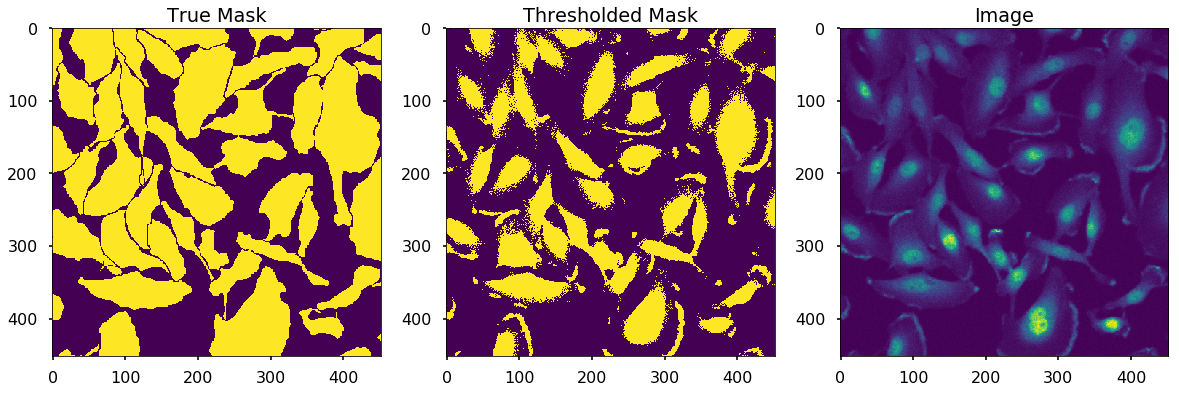

In [59]:
f, axs = plt.subplots(1,3,figsize=(20,15))
plt.subplot(1,3,1)
plt.title("True Mask")
plt.imshow(val)
plt.subplot(1,3,2)
plt.title("Thresholded Mask")
plt.imshow(cyto)
plt.subplot(1,3,3)
plt.title("Image")
plt.imshow(I[win_cyto:-win_cyto,win_cyto:-win_cyto])
print(cytoplasm_predictions.shape)

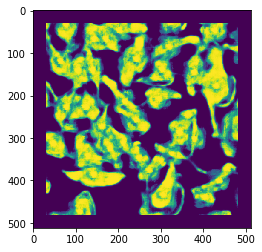

In [29]:
plt.imshow(cytoplasm_predictions[0,0,:,:])

In [42]:
plt.style.available

[u'seaborn-darkgrid',
 u'Solarize_Light2',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'_classic_test',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn',
 u'seaborn-poster',
 u'seaborn-bright',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'fast',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']